# EMA Optimization (20–200): Grid Search using QF-Lib

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib

if not hasattr(matplotlib.rcParams, "_get"):
    matplotlib.rcParams._get = matplotlib.rcParams.get

import matplotlib.pyplot as plt

# tambahkan path src
sys.path.append("../src")

from data_loader import load_ohlcv_csv
from indicators import calculate_ema
from strategy import ema_vs_price_signals
from backtest import run_backtest
from qflib_metrics import qflib_metrics_from_returns

In [2]:
data_path = "../data/OKX_BTCUSDT, 1D.csv"
df = load_ohlcv_csv(data_path)

df.head()

,open,high,low,close,EMA,Oversold HWO Up,Overbought HWO Down,HWO Up,HWO Down,ATR,MACD,Signal
time,,,,,,,,,,,,
2025-01-17 00:00:00+00:00,99990.9,105847.4,99950.1,104084.4,87477.819959,NaN,NaN,NaN,NaN,3858.413818,806.234733,45.098916
2025-01-18 00:00:00+00:00,104084.5,104984.0,102288.0,104551.6,87780.010756,NaN,NaN,NaN,NaN,3775.384260,1263.568044,288.792741
2025-01-19 00:00:00+00:00,104551.6,106448.6,99639.4,101334.0,88019.904371,NaN,NaN,NaN,NaN,3992.085384,1350.803339,501.194861
2025-01-20 00:00:00+00:00,101334.0,109800.0,99526.4,102264.3,88272.017568,NaN,NaN,NaN,78.924812,4440.765000,1477.968275,696.549544
2025-01-21 00:00:00+00:00,102263.9,107285.8,100111.0,106150.1,88588.443806,NaN,NaN,NaN,NaN,4636.053214,1870.734327,931.386500


In [3]:
def optimize_ema_span(
    df: pd.DataFrame,
    span_min: int = 20,
    span_max: int = 200,
    step: int = 5,
    initial_capital: float = 10000.0
) -> pd.DataFrame:
    """
    Melakukan grid search EMA span dari span_min sampai span_max
    dengan step tertentu. Untuk setiap span:
    - Hitung EMA
    - Generate sinyal EMA vs price
    - Jalankan backtest
    - Hitung metrik dengan QF-Lib (Sharpe, CAGR, dll)

    Return:
        DataFrame dengan index = span,
        kolom = total_return, cagr, sharpe_ratio, annualised_vol, max_drawdown, avg_drawdown_duration
    """
    results = []

    for span in range(span_min, span_max + 1, step):
        df_copy = df.copy()
        df_copy["EMA"] = calculate_ema(df_copy["close"], span=span)

        positions = ema_vs_price_signals(df_copy, ema_col="EMA")
        bt = run_backtest(df_copy, positions, initial_capital=initial_capital)

        metrics = qflib_metrics_from_returns(bt["strategy_ret"])
        metrics["span"] = span

        results.append(metrics)

    results_df = pd.DataFrame(results).set_index("span").sort_index()
    return results_df

In [4]:
results_df = optimize_ema_span(df, span_min=20, span_max=200, step=5)
results_df.head()

,total_return,cagr,sharpe_ratio,annualised_vol,max_drawdown,avg_drawdown_duration
span,,,,,,
20,-0.104316,-0.088388,-0.324572,0.214047,-0.245581,73.750000
25,-0.081157,-0.068629,-0.225548,0.213503,-0.204020,73.250000
30,0.031654,0.026522,0.230884,0.198572,-0.136090,35.750000
35,0.086330,0.072032,0.453254,0.195519,-0.116295,25.636364
40,0.054304,0.045421,0.323472,0.197400,-0.131742,28.400000


In [5]:
# urutkan berdasarkan Sharpe (desc), lalu CAGR (desc)
sorted_df = results_df.sort_values(
    by=["sharpe_ratio", "cagr"],
    ascending=[False, False]
)

best_span = sorted_df.index[0]
best_metrics = sorted_df.iloc[0]

print("Best EMA span:", best_span)
print("\nMetrics:")
display(best_metrics)

Best EMA span: 45

Metrics:


total_return              0.089383
cagr                      0.074562
sharpe_ratio              0.460865
annualised_vol            0.198824
max_drawdown             -0.146291
avg_drawdown_duration    23.416667
Name: 45, dtype: float64

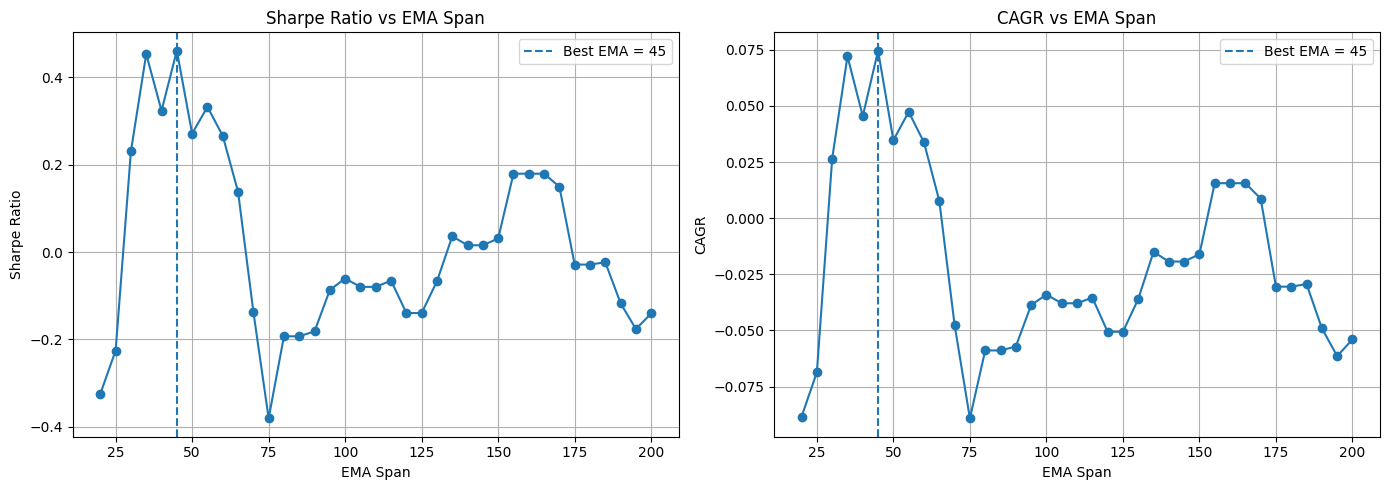

In [6]:
plt.figure(figsize=(14,5))

# Sharpe
plt.subplot(1, 2, 1)
plt.plot(results_df.index, results_df["sharpe_ratio"], marker="o")
plt.axvline(best_span, linestyle="--", label=f"Best EMA = {best_span}")
plt.title("Sharpe Ratio vs EMA Span")
plt.xlabel("EMA Span")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.grid(True)

# CAGR
plt.subplot(1, 2, 2)
plt.plot(results_df.index, results_df["cagr"], marker="o")
plt.axvline(best_span, linestyle="--", label=f"Best EMA = {best_span}")
plt.title("CAGR vs EMA Span")
plt.xlabel("EMA Span")
plt.ylabel("CAGR")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

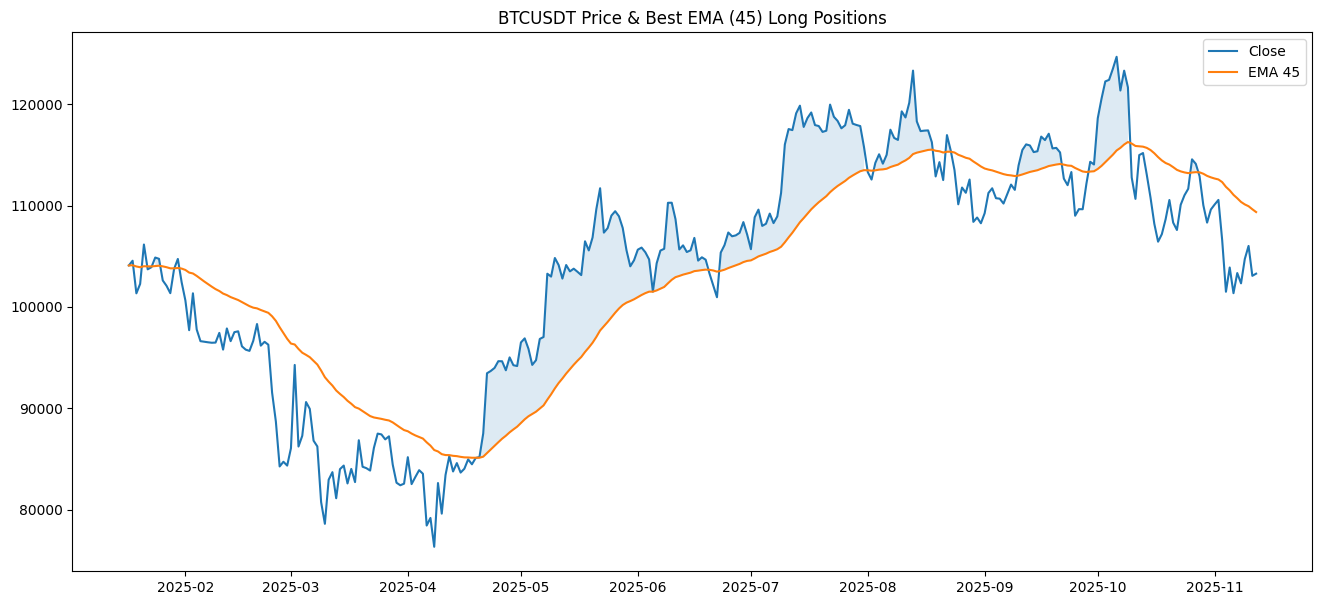

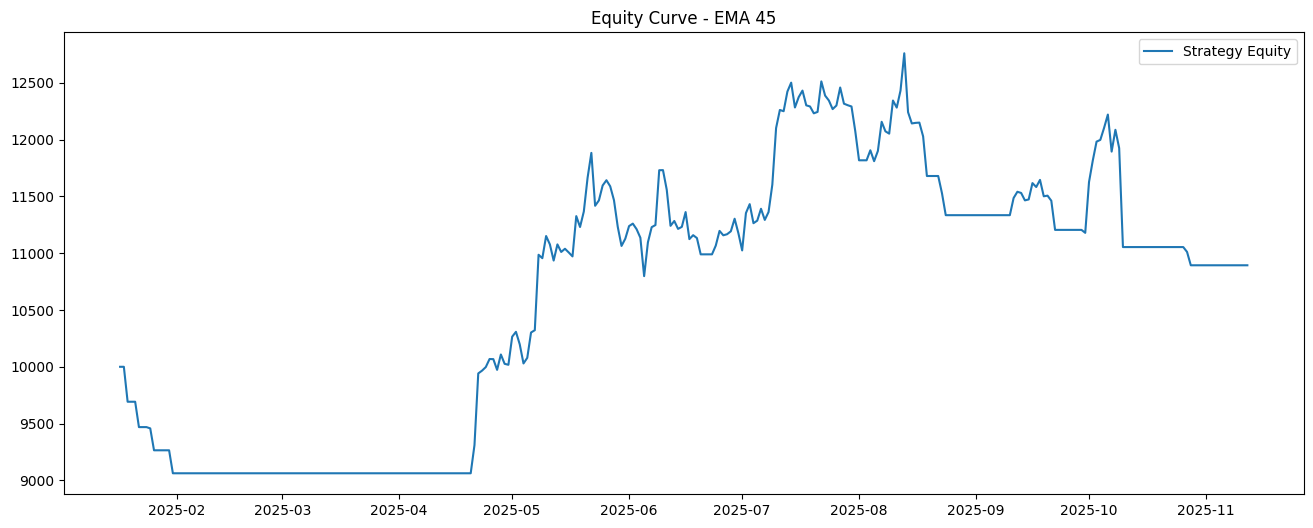

In [7]:
df_opt = df.copy()
df_opt["EMA"] = calculate_ema(df_opt["close"], span=best_span)

positions_opt = ema_vs_price_signals(df_opt, ema_col="EMA")
bt_opt = run_backtest(df_opt, positions_opt, initial_capital=10000.0)

# plot harga + EMA + shading posisi
plt.figure(figsize=(16,7))
plt.plot(df_opt.index, df_opt["close"], label="Close")
plt.plot(df_opt.index, df_opt["EMA"], label=f"EMA {best_span}")
plt.fill_between(df_opt.index, df_opt["close"], df_opt["EMA"],
                 where=(positions_opt==1),
                 alpha=0.15)
plt.title(f"BTCUSDT Price & Best EMA ({best_span}) Long Positions")
plt.legend()
plt.show()

# plot equity curve
plt.figure(figsize=(16,6))
plt.plot(bt_opt.index, bt_opt["equity_curve"], label="Strategy Equity")
plt.title(f"Equity Curve - EMA {best_span}")
plt.legend()
plt.show()

## Kesimpulan

- **EMA terbaik:** span `{{best_span}}` (perbarui setelah menjalankan notebook).
- **Sharpe Ratio:** `{{best_metrics.sharpe_ratio}}` dan **CAGR:** `{{best_metrics.cagr}}` (nilai aktual akan muncul setelah eksekusi).
- Range EMA ini tampak cocok untuk BTC karena menyeimbangkan sensitivitas terhadap perubahan tren tanpa terlalu bising; strategi fokus pada pergerakan menengah yang terlihat dominan pada data in-sample.
- Catatan: hasil ini murni in-sample dan belum dibagi train/test, sehingga perlu validasi lanjutan sebelum digunakan secara live.